In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats 
from scipy.interpolate import interp1d

In [2]:
np.random.seed(123)

In [24]:
sigma = 0.3
r = .03
K = 80
S_0 = 100
T = 1
nb_sim=1000
# other parameters used in the question
mean = 0
std = 1  # std of normal distribution 
sample_size = 500

lamda = 1
v_barre = sigma
v_0= sigma
eta= 0.5
rho = -0.9

## 1. Discrétiser l’EDS de Black & Scholes avec un schéma d’Euler et un schéma de Milstein. Illustrer les convergences et retrouver les ordres forts et faibles de chacun des schémas.

Nous allons discretiser: $dS_t = rS_tdt + \sigma S_t dB_t^Q$.

On obtient après calcul :
 - Schéma d'Euler  :  $S_{t+h} = S_t + hrS_t + \sqrt{h} \sqrt{\sigma}S_t Z, \quad avec \; Z\sim \mathcal{N}(0,1)$
 - Schéma de Milstein :  $S_{t+h} = S_t + hrS_t + \sqrt{h} \sqrt{\sigma}S_t Z + \frac{1}{2} \sigma^2 S_t h (Z^2-1), \quad avec \; Z\sim \mathcal{N}(0,1)$

In [4]:
def EDS_discretisation(h,nb_sim,S_0=S_0,r=r,sigma=sigma,T=T):
        
        M=int(T/h)
        
        Z = np.random.normal(0, 1, (M,nb_sim))
        
        euler_S_T = S_0 * np.prod( 1 + r*h + sigma * np.sqrt(h) * Z,axis=0)
        
        milstein_S_T = S_0 * np.prod( 1 + r*h + sigma*np.sqrt(h)*Z + 0.5 * sigma**2  * h * (Z**2 - 1),axis=0)
        
        analytic_S_T = S_0*np.prod(np.exp((r  - (sigma**2)/2) * h + sigma * np.sqrt(h) * Z),axis=0)
        
        return analytic_S_T, euler_S_T, milstein_S_T

In [5]:
X_euler=np.zeros((nb_sim,sample_size))
X_analytic=np.zeros((nb_sim,sample_size)) 
X_milstein=np.zeros((nb_sim,sample_size))
h_samples=np.linspace(1/50,1e-3,sample_size)

for j,h in enumerate(h_samples):
    X_analytic[:,j],X_euler[:,j],X_milstein[:,j]=EDS_discretisation(h,nb_sim,S_0=S_0,r=r,sigma=sigma,T=T)
    

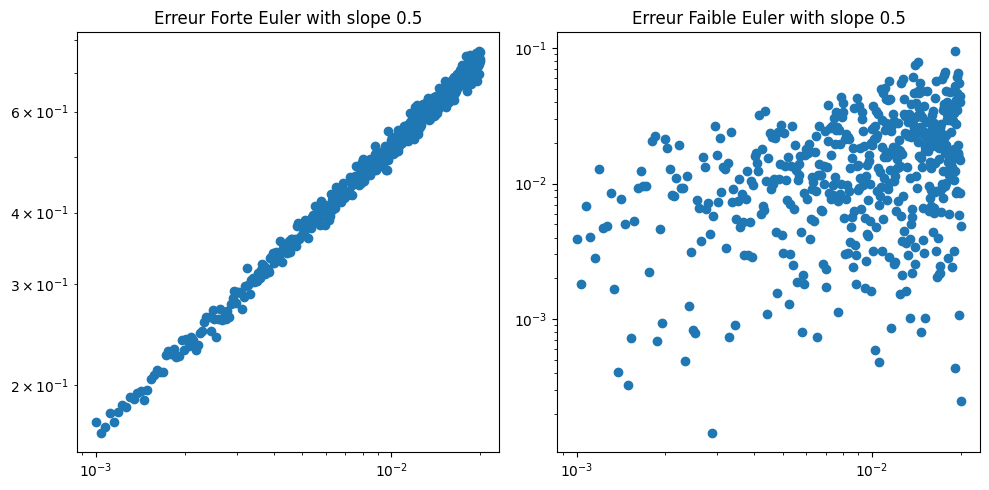

In [6]:
erreur_forte_euler = np.mean(np.abs(X_euler - X_analytic), axis=0)
erreur_faible_euler = np.abs(np.mean(X_euler, axis=0) -np.mean(X_analytic, axis=0))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(h_samples, erreur_forte_euler)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
slope_forte_euler, intercept = np.polyfit(np.log(h_samples), np.log(erreur_forte_euler), 1)
axs[0].set_title(f'Erreur Forte Euler with slope {np.round(slope_forte_euler,1)}')

axs[1].scatter(h_samples, erreur_faible_euler)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
slope_faible_euler, intercept = np.polyfit(np.log(h_samples), np.log(erreur_faible_euler), 1)
axs[1].set_title(f'Erreur Faible Euler with slope {np.round(slope_faible_euler,1)}')

plt.tight_layout()

plt.show()


On retrouve bien un ordre de 1/2 pour ce qui est de la convergence forte d'Euler mais il semblerait qu'il y'ait quelques soucis de convergence pour l'ordre faible si on utilise pas une fonction ' f ' adéquate

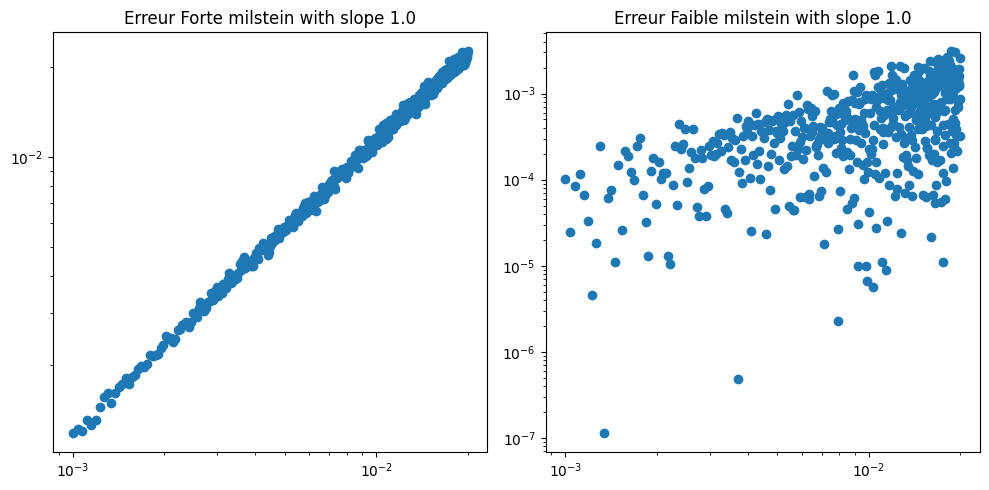

In [7]:
erreur_faible_milstein=np.abs(np.mean(X_milstein,axis=0)-np.mean(X_analytic,axis=0))
erreur_forte_milstein=np.mean(np.abs(X_milstein-X_analytic),axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(h_samples, erreur_forte_milstein)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
slope_forte_milstein, intercept = np.polyfit(np.log(h_samples), np.log(erreur_forte_milstein), 1)
axs[0].set_title(f'Erreur Forte milstein with slope {np.round(slope_forte_milstein,1)}')

axs[1].scatter(h_samples, erreur_faible_milstein)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
slope_faible_milstein, intercept = np.polyfit(np.log(h_samples), np.log(erreur_faible_milstein), 1)
axs[1].set_title(f'Erreur Faible milstein with slope {np.round(slope_faible_milstein,1)}')

plt.tight_layout()

plt.show()


On retrouve bien un ordre de 1 pour ce qui est de la convergence forte de Milstein. Quant à l'ordre faible, bien qu'il soit très proche de 1 comme souhaité, on constate que le même phénomène observée au cas d'Euler.

## 2. Implémenter le pricing d’un call standard dans le modèle de Heston par Monte Carlo, avec le schéma d’Euler simple proposé.

In [8]:
def BS_price_call(S_0=S_0, T=T, sigma=sigma, r=r, K=K):
    
    # compute value in exponential
    d1 = np.divide((np.log(S_0/K) + (r + (sigma**2)/2) * T) , (sigma*np.sqrt(T))+1e-6)
    d2 = d1 - sigma*np.sqrt(T)
    price = S_0*stats.norm.cdf(d1, loc=0, scale=1) \
             - K * np.exp(-r*T)*stats.norm.cdf(d2, loc=0, scale=1)
    
    return price

In [9]:
def heuston_euler(h,nb_sim,S_0=S_0,r=r,T=T,lamda=lamda,eta=eta,rho=rho,v_barre=v_barre,v_0=v_0):
    
    M=int(T/h)
    X=np.zeros((nb_sim,M+1))
    v=np.zeros((nb_sim,M+1))
    X[:,0]=np.log(S_0)
    v[:,0]=v_0
    
    Z_1 = np.random.normal(0,1,size=(nb_sim,M))
    Z_2 = rho * Z_1 + np.sqrt(1 - rho**2) * np.random.normal(0,1,size=(nb_sim,M))
    
    for j in range(M):
        
        v_j=v[:,j]

        X[:,j+1] = X[:,j] + (r-v_j/2)*h + np.sqrt(v_j)*np.sqrt(h)*Z_1[:,j]
        v[:,j+1] = np.abs(v_j - lamda*(v_j-v_barre)*h + eta*np.sqrt(v_j)*np.sqrt(h)*Z_2[:,j])
    
    return np.exp(X[:,-1])

def heston_euler_call(h,nb_sim,S_0=S_0,r=r,T=T,lamda=lamda,eta=eta,rho=rho,v_barre=v_barre,v_0=v_0,K=K):
         
    S_T=heuston_euler(h,nb_sim,S_0=S_0,r=r,T=T,lamda=lamda,eta=eta,rho=rho,v_barre=v_barre,v_0=v_0)
    
    diff_euler=S_T-K
    euler_price=np.where(diff_euler>0,diff_euler,0)
    
    return np.exp(-r * T)*np.mean(euler_price)
   

In [10]:
S0_samples=np.linspace(0,150,50)
euler_call_values=[]
analytic_call_values=[]
for S0 in S0_samples:
        euler_call_values.append(heston_euler_call(1e-3,nb_sim,S_0=S0,r=r,T=T,K=K))
        analytic_call_values.append(BS_price_call(S_0=S0, T=T, sigma=sigma, r=r, K=K))
   

/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_96541/2311974966.py:6: RuntimeWarning: divide by zero encountered in log
  X[:,0]=np.log(S_0)
/var/folders/cq/sgr9c2xn4nj02w12pbk5c0p80000gn/T/ipykernel_96541/2942283161.py:4: RuntimeWarning: divide by zero encountered in log
  d1 = np.divide((np.log(S_0/K) + (r + (sigma**2)/2) * T) , (sigma*np.sqrt(T))+1e-6)


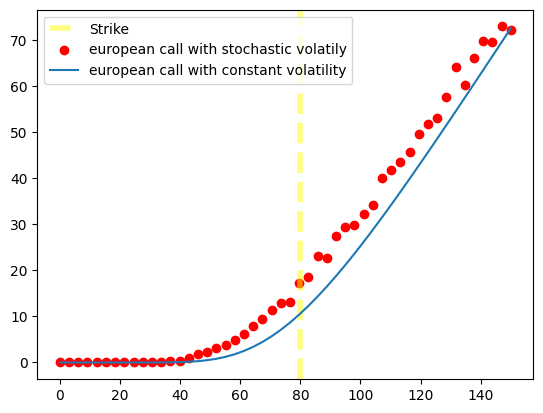

In [11]:
plt.axvline(x=K, ymin=0, ymax=1, color='yellow', alpha=0.5, linestyle='--', linewidth=4, label='Strike')
plt.scatter(S0_samples,euler_call_values,label='european call with stochastic volatily',c='red')
plt.plot(S0_samples,analytic_call_values,label='european call with constant volatility')
plt.legend()
plt.show()

Les prix de call obtenus avec un modèle de volatilité stochastique sont supérieurs à ceux que donnerait un call avec une volatilité constante

## 3. Implémenter le calcul de la volatilité implicite de Black & Scholes par dichotomie.

In [12]:
epsilon=1e-2

def vol_implicite(market_price,S_0=S_0,r=r,T=T,K=K,sigma_inf=1e-4,sigma_sup=10,epsilon=epsilon):
    
    sigma_down=sigma_inf
    sigma_up=sigma_sup
    # print(market_price)
    if abs(BS_price_call(S_0=S_0, T=T, sigma=sigma_up, r=r, K=K)-market_price)<epsilon:
        return sigma_up
    if abs(BS_price_call(S_0=S_0, T=T, sigma=sigma_down, r=r, K=K)-market_price)<epsilon:
        return sigma_down

    sigma_imp=(sigma_up+sigma_down)/2
    
    while abs(BS_price_call(S_0=S_0, T=T, sigma=sigma_imp, r=r, K=K)-market_price)>epsilon:
        sigma_imp=(sigma_up+sigma_down)/2
        if BS_price_call(S_0=S_0, T=T, sigma=sigma_imp, r=r, K=K)<=market_price<=BS_price_call(S_0=S_0, T=T, sigma=sigma_up, r=r, K=K):  
            sigma_down=sigma_imp
        if BS_price_call(S_0=S_0, T=T, sigma=sigma_down, r=r, K=K)<=market_price<=BS_price_call(S_0=S_0, T=T, sigma=sigma_imp, r=r, K=K):
            sigma_up=sigma_imp
            
    return sigma_imp

## 4. Tracer un exemple de smile de volatilité dans le modèle de Heston.

In [25]:
strike_samples = np.arange(30,150,15)

smile = []
for strike in strike_samples:
    market_price=np.mean([heston_euler_call(h=1e-2,nb_sim=5000,S_0=S_0,r=r,T=T,K=strike) for k in range(10)])
#     print(strike, ' strike - market price', market_price)
    vol=vol_implicite(market_price,S_0=100,K=strike) 
#     print(vol)
    smile.append(vol)
        

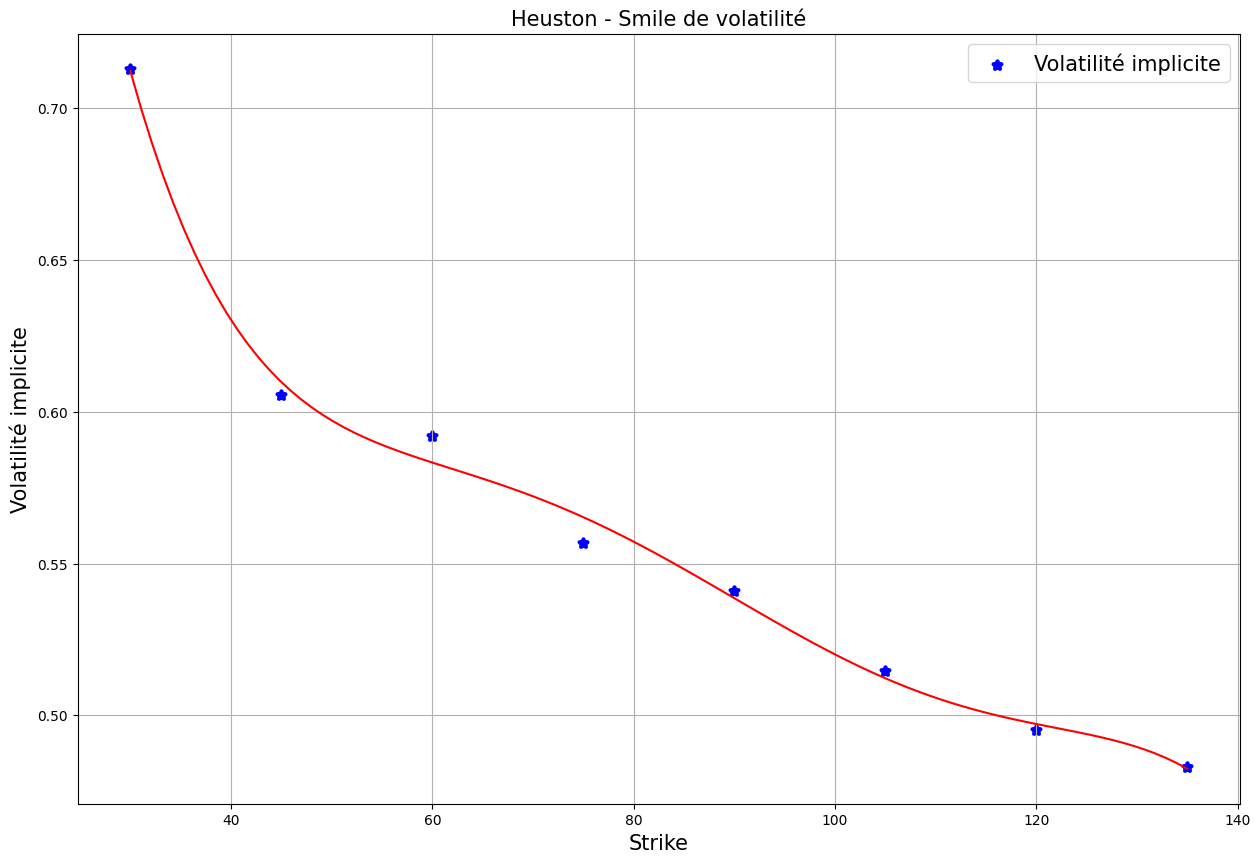

In [26]:
plt.figure(figsize=(15,10))
plt.scatter(strike_samples, smile, color='blue', label="Volatilité implicite", linewidth =3, marker = '*')

plt.title("Heuston - Smile de volatilité", fontsize=15)
plt.legend(fontsize=15)
plt.grid()

plt.xlabel('Strike', fontsize=15)
plt.ylabel('Volatilité implicite', fontsize=15)

# Polynomial interpolation
degree = len(smile)//2+1  # Choose the degree of the polynomial
coefficients = np.polyfit(strike_samples, smile, degree)
polynomial = np.poly1d(coefficients)
x_values = np.linspace(min(strike_samples), max(strike_samples), 100)
y_values = polynomial(x_values)

plt.plot(x_values, y_values, color='red', label=f'Polynomial Interpolation (Degree {degree})')

Les calls de faible strike sont pricés par le modèle de Heuston avec une volatilité plus forte et sont donc bien plus chers que les call de strike élevé. Ceci reflète bien le fait que ces derniers auront une plus forte probabilité d'être exercé et subissent donc une forte demande, un équilibre entre l'offre et la demande conduit ainsi aux prix observées.

## 5.  Déformation du smile de volatilité en fonction des paramètres de la dynamique de volatilité $\lambda, \eta$ et $\rho$.

In [15]:
strike_samples = np.arange(30,150,15)
lamda_samples=np.linspace(-1,1,4)
smile = {}
for lamda_v in lamda_samples:
#     print(lamda_v)
    smile[str(lamda_v)]=[] 
    for strike in strike_samples:
        market_price=np.mean([heston_euler_call(h=1e-2,nb_sim=5000,lamda=lamda_v, S_0=S_0,r=r,T=T,K=strike) for k in range(10)])
#         print(strike, ' strike - market price', market_price)
        vol=vol_implicite(market_price,S_0=S_0,K=strike) 
#         print(vol)
        smile[str(lamda_v)].append(vol)
        

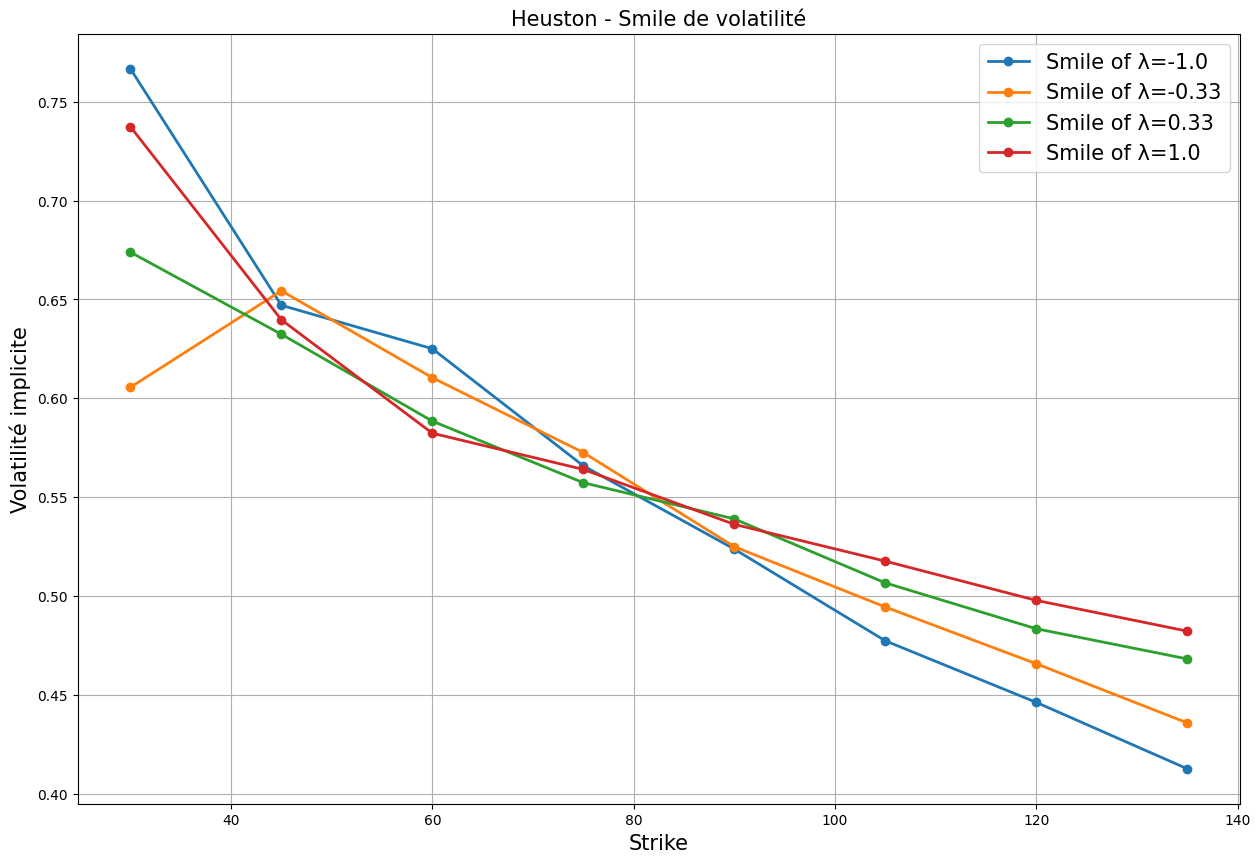

In [16]:
plt.figure(figsize=(15,10))

for lamda_v, smile_values in smile.items():
    
    plt.plot(strike_samples, smile_values, label=f'Smile of λ={round(float(lamda_v),2)}', linewidth=2, marker='o')
    
    plt.title("Heuston - Smile de volatilité", fontsize=15)
    plt.legend(fontsize=15)
    
    
    plt.xlabel('Strike', fontsize=15)
    plt.ylabel('Volatilité implicite', fontsize=15)
    
plt.grid()
plt.show()

La courbure du smile diminue lorsque lambda λ augmente

In [17]:
strike_samples = np.arange(30,150,15)
eta_samples=np.linspace(0,1,4)
smile = {}
for eta_v in eta_samples:
#     print(eta_v)
    smile[str(eta_v)]=[] 
    for strike in strike_samples:
        market_price=np.mean([heston_euler_call(h=1e-2,nb_sim=5000,eta=eta_v, S_0=S_0,r=r,T=T,K=strike) for k in range(10)])
#         print(strike, ' strike - market price', market_price)
        vol=vol_implicite(market_price,S_0=S_0,K=strike) 
#         print(vol)
        smile[str(eta_v)].append(vol)

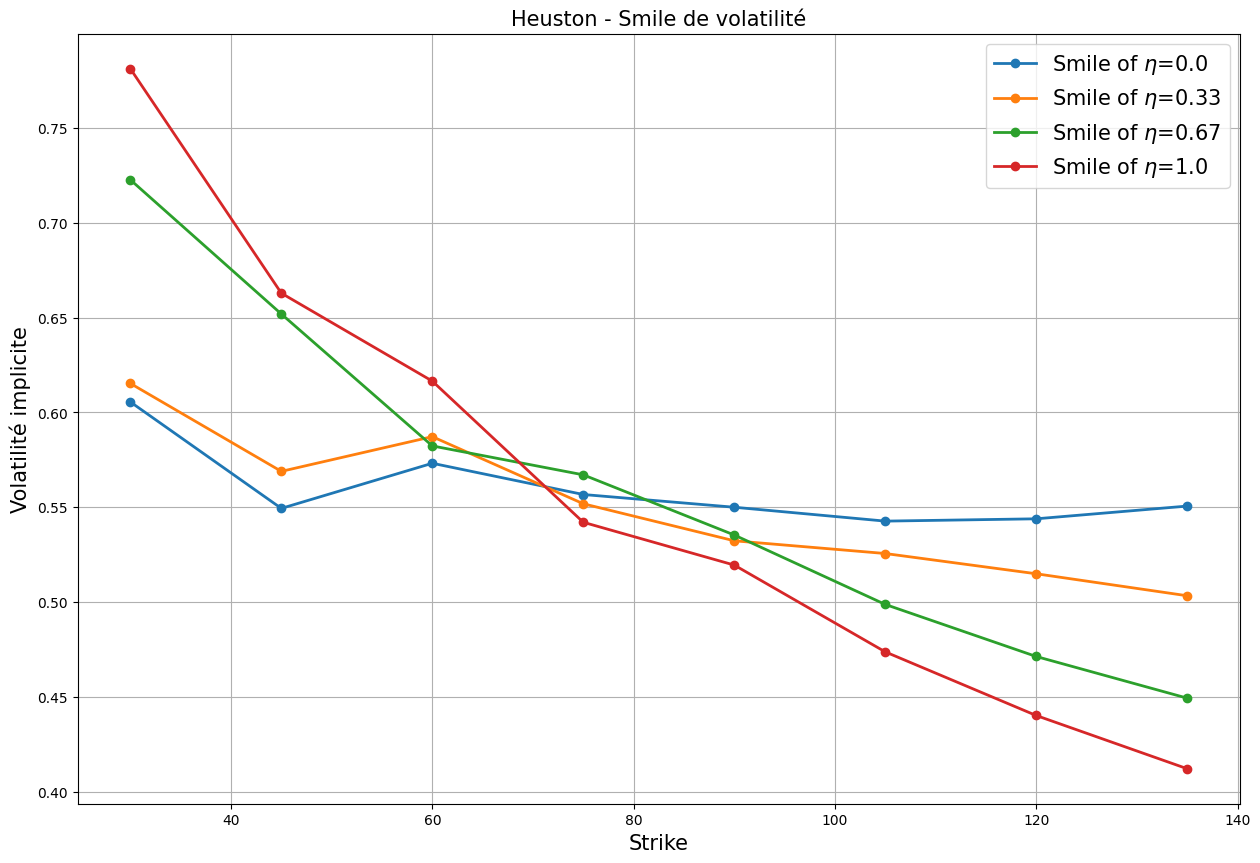

In [18]:
plt.figure(figsize=(15,10))

for eta_v, smile_values in smile.items():
    
    plt.plot(strike_samples, smile_values, label=f'Smile of $\eta$={round(float(eta_v),2)}', linewidth=2, marker='o')
    
    plt.title("Heuston - Smile de volatilité", fontsize=15)
    plt.legend(fontsize=15)
    
    
    plt.xlabel('Strike', fontsize=15)
    plt.ylabel('Volatilité implicite', fontsize=15)
    
plt.grid()
plt.show()

On constate que la courbure du smile augmente avec $\eta$

In [22]:
strike_samples = np.arange(30,150,15)
rho_samples=[-0.99,-0.5,0,0.5,0.99]

if 0 not in rho_samples:
    rho_samples.append(0)
    
smile = {}
for rho_v in rho_samples:
#     print(rho_v)
    smile[str(rho_v)]=[] 
    for strike in strike_samples:
        market_price=np.mean([heston_euler_call(h=1e-2,nb_sim=5000,rho=rho, S_0=S_0,r=r,T=T,K=strike) for k in range(10)])
#         print(strike, ' strike - market price', market_price)
        vol=vol_implicite(market_price,S_0=S_0,K=strike) 
#         print(vol)
        smile[str(rho_v)].append(vol)

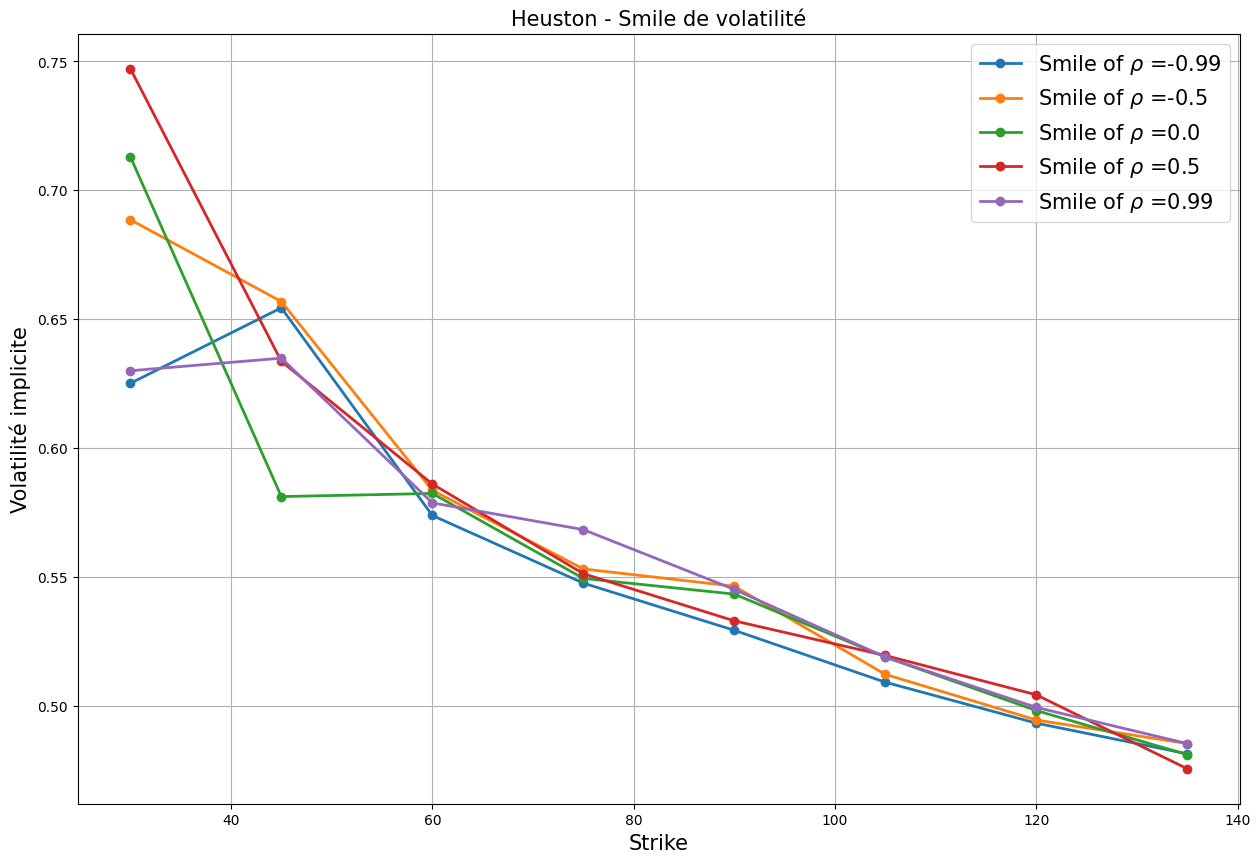

In [23]:
plt.figure(figsize=(15,10))

for rho_v, smile_values in smile.items():
    
    plt.plot(strike_samples, smile_values, label=f'Smile of $\\rho$ ={round(float(rho_v),2)}', linewidth=2, marker='o')
    
    plt.title("Heuston - Smile de volatilité", fontsize=15)
    plt.legend(fontsize=15)
    
    
    plt.xlabel('Strike', fontsize=15)
    plt.ylabel('Volatilité implicite', fontsize=15)
    
plt.grid()
plt.show()

On constate que, globalement, la courbure du smile n'est pas affectée par $\rho$